# Reading and editing a topography
A topograph/bathymetry is needed to create the domain of interpolation (land-sea mask). The topography/bathymetry is usually extracted from a netCDF file.     
Adapted topographies:
* General Bathymetric Chart of the Oceans ([GEBCO](https://www.gebco.net/))
* [EMODnet Bathymetry](http://www.emodnet-bathymetry.eu)
* Other topographies can be used as long as they define the netCDF variables `lon`, `lat` and `bat` (positive above sea-level and negative below, in `DIVAnd` however, the convention is that `z` is positive in sea water).

This notebook illustrates how the land-sea mask can be modified, for example to exclude a lake.

In [1]:
using DIVAnd
using PyPlot
using Dates
using Statistics

The full EMODnet Bathymetry is a quite big file (~1GB) that can be obtained from the bathymetry portal: http://portal.emodnet-bathymetry.eu/?menu=19. In the present notebook we will work with the GEBCO bathymetry with a resolution that has been decreased.

Note that an extremely fine bathymetry is not necessary when working on large domains.

## Data download and domain selection
We create a domain encompassing the north of Corsica.

In [2]:
dx = dy = 0.125
lonr = 2.5:dx:12.
latr = 42.3:dy:44.6

# https://dox.ulg.ac.be/index.php/s/RSwm4HPHImdZoQP/download  gebco_30sec_4.nc
# https://dox.ulg.ac.be/index.php/s/wS6Y8P8NhIF60eG/download  gebco_30sec_8.nc
# https://dox.ulg.ac.be/index.php/s/U0pqyXhcQrXjEUX/download  gebco_30sec_16.nc

bathname = "gebco_30sec_8.nc"

if !isfile(bathname)
    @info("Download bathymetry")
    download("https://dox.ulg.ac.be/index.php/s/wS6Y8P8NhIF60eG/download",bathname)
else
    @info("Bathymetry file already downloaded")
end

bathisglobal = true;

┌ Info: Download bathymetry
└ @ Main In[2]:12
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 55.7M  100 55.7M    0     0  6364k      0  0:00:08  0:00:08 --:--:-- 7221k


We have two main tools to load the bathymetry:
1. `DIVAnd.extract_bath` loads the bathymetry at the resolution defined in the netCDF file while 
2. `DIVAnd.load_bath` reduces the resolution to match the resolution of the analysis.

### Extract bathymetry

In [3]:
?extract_bath

search: extract_bath



```
bx,by,b = DIVAnd.extract_bath(bath_name,isglobal,xi,yi)
```

Extract the bathymetry from the NetCDF file `bathname`. The parameter `isglobal`  is true if the NetCDF file covers the whole globe and thus the last longitude point can be considered to be right next to the first longitude point. `xi` and `yi` are vectors defining the bounding box of the data. No interpolation is performed.

**Convention:** b is positive in the water and negative in the air.


In [4]:
bx,by,b = extract_bath(bathname,true,lonr,latr)
@show size(b);

size(b) = (147, 39)


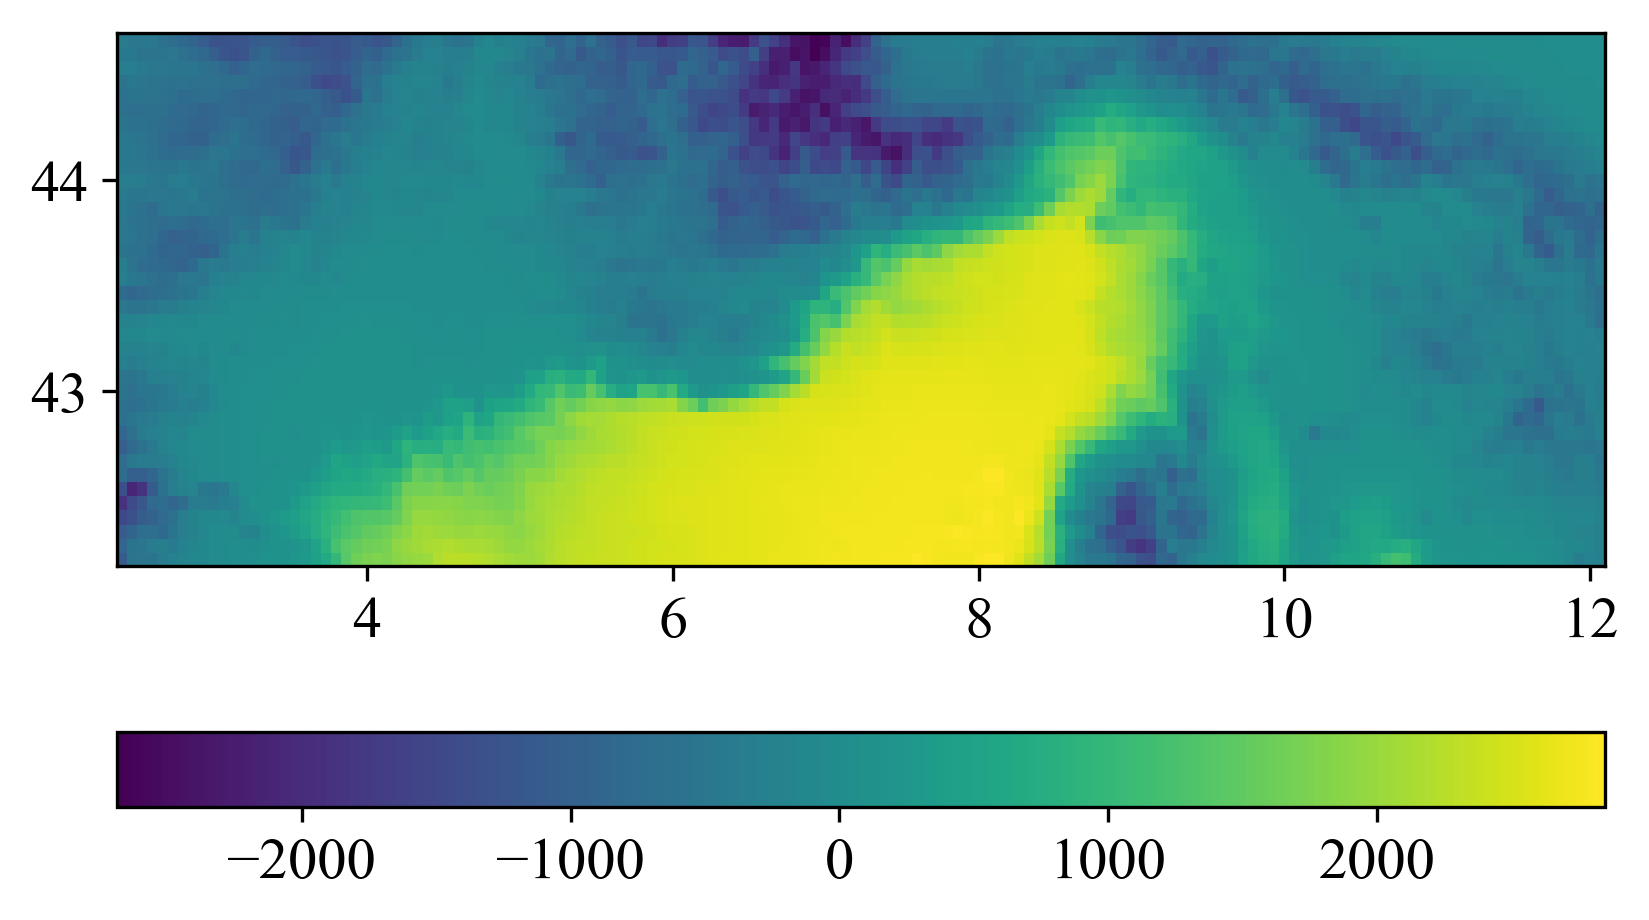

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[5]:3
└ @ Core In[5]:3


In [5]:
pcolor(bx, by, permutedims(b, [2, 1])); 
colorbar(orientation="horizontal")
ax = gca()
ax.set_aspect(1/cos(mean([ylim()...]) * pi/180))

### Load bathymetry
With a change of its original resolution

In [6]:
?load_bath

search: load_bath



```
xi,yi,bath = DIVAnd.load_bath(bath_name,isglobal,xi,yi)
```

Load the bathymetry from the NetCDF file `bathname`. The parameter `isglobal` is true if the NetCDF file covers the whole globe and thus the last longitude point can be considered to be right next to the first longitude point. `xi` and `yi` are vectors containing the longitude and latitude grid onto which the bathymetry should be interpolated.


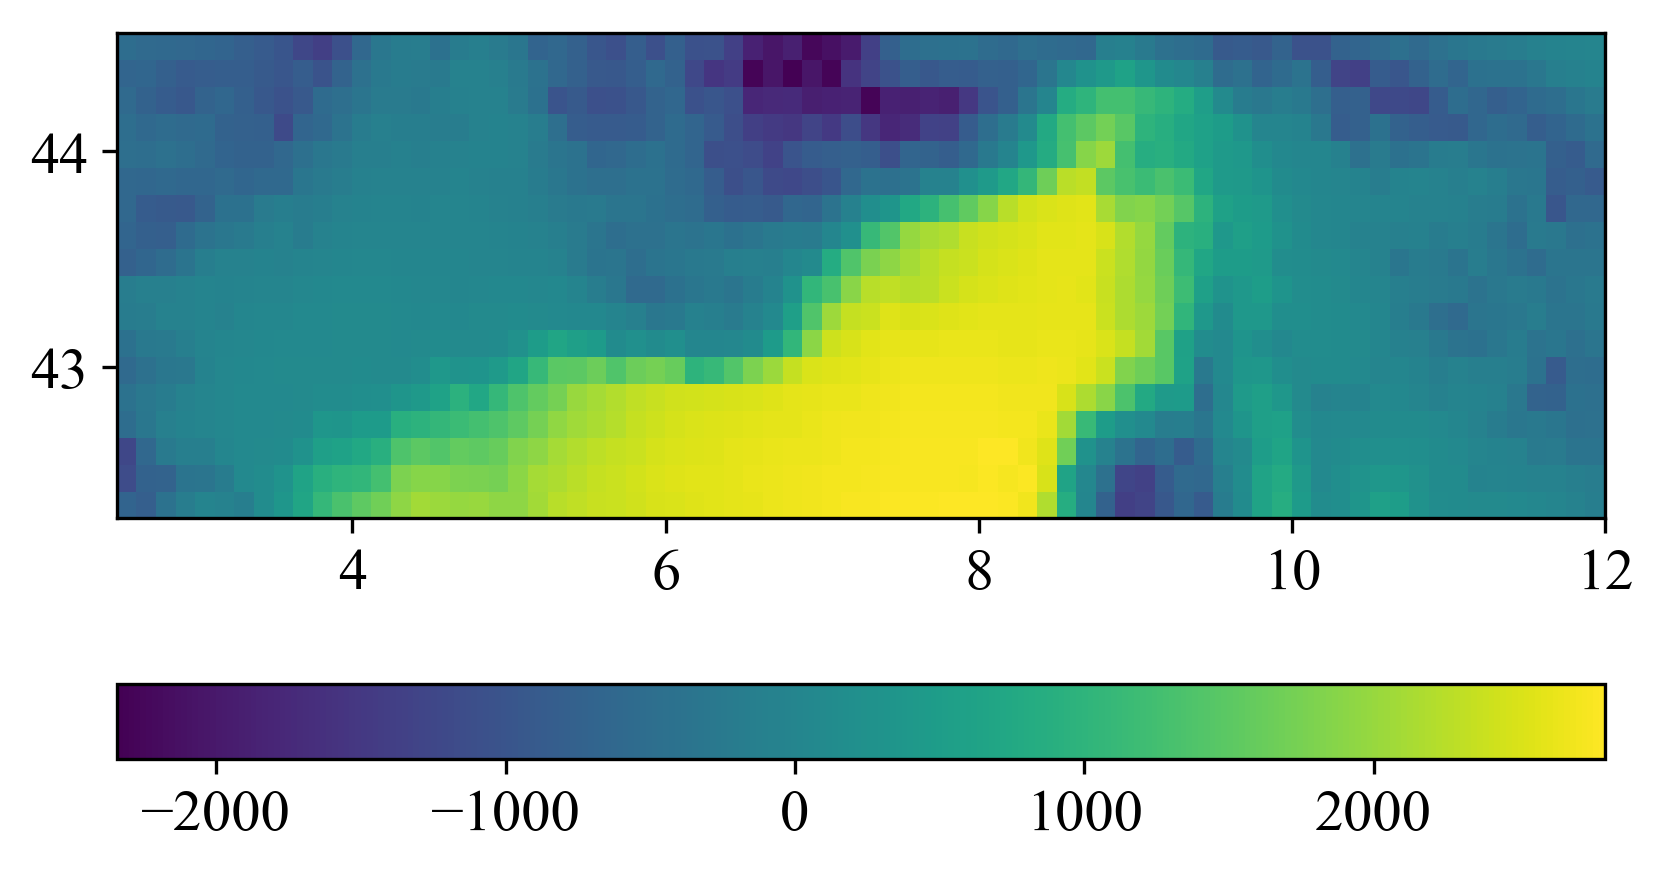

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[7]:5
└ @ Core In[7]:5


In [7]:
bx,by,b = load_bath(bathname,true,lonr,latr)

pcolor(bx,by,permutedims(b, [2, 1])); 
colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))

#@show size(b)

## Mask creation
We start by defining the mask as a 3D matrix containing only `False`, then we set the values to `True` when the actual depth is deeper than the selected values stored in the vector `depthr`.

In [8]:
depthr = [0,10,20,500]
mask = falses(size(b,1),size(b,2),length(depthr))

for k = 1:length(depthr)
    for j = 1:size(b,2)
        for i = 1:size(b,1)
            mask[i,j,k] = b[i,j] >= depthr[k]
        end
    end
end
@show typeof(mask)

typeof(mask) = BitArray{3}


BitArray{3}

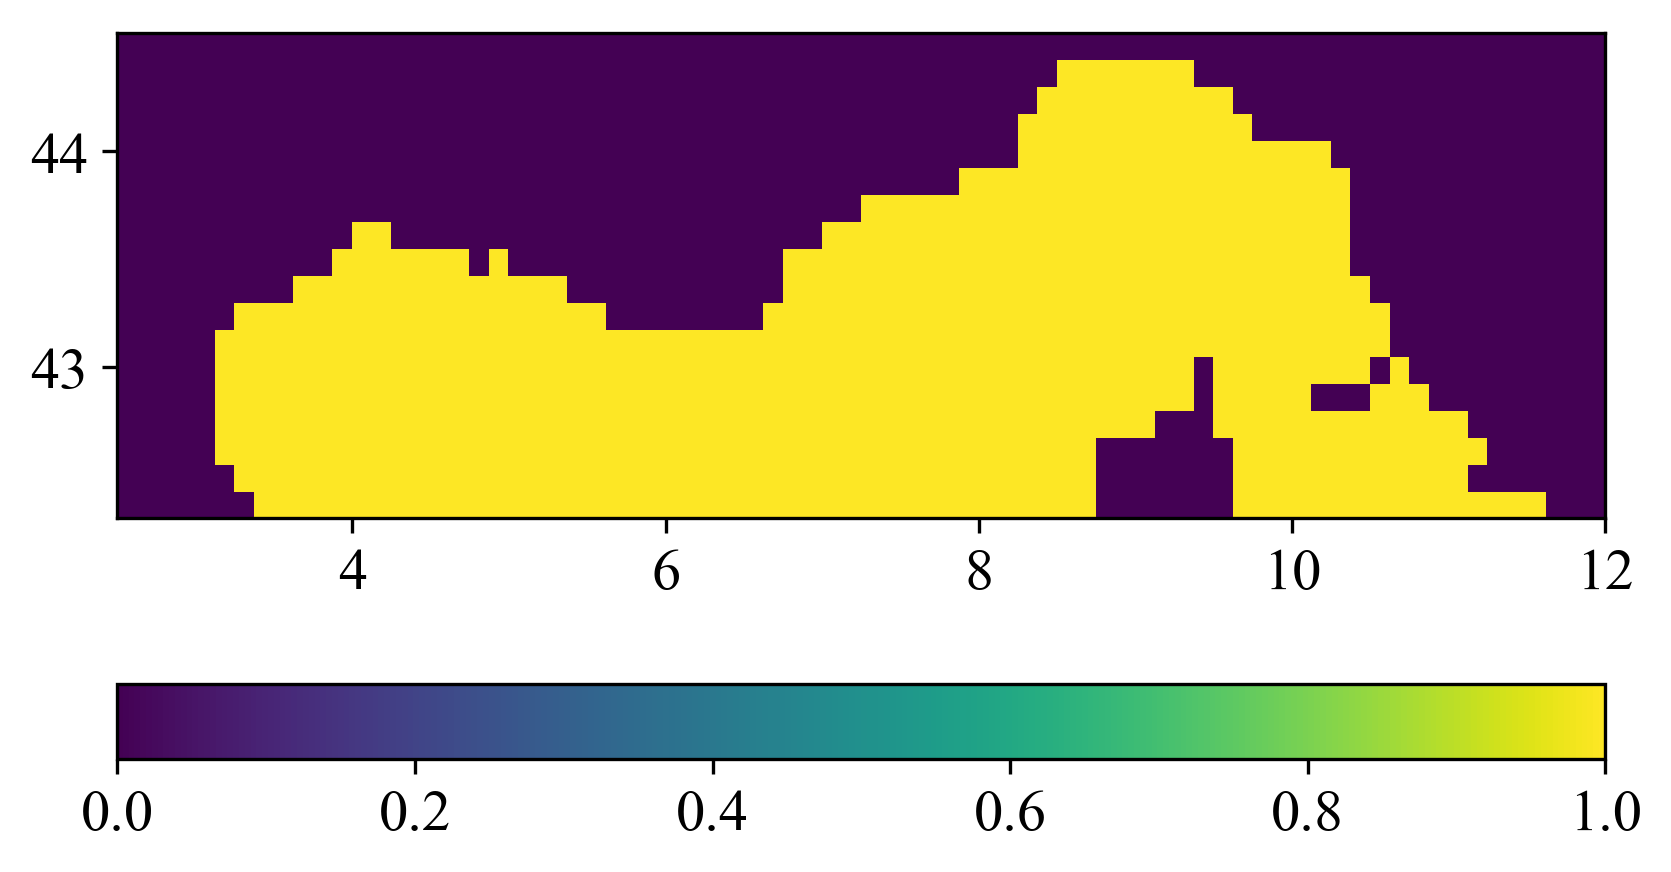

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[9]:3
└ @ Core In[9]:3


In [9]:
pcolor(bx,by,Float64.(permutedims(mask[:,:,1], [2, 1])))
colorbar(orientation="horizontal")
gca().set_aspect(1/cos(mean([ylim()...]) * pi/180)) # fixes the aspect ratio

Another solution is to use the `load_mask` function:

In [10]:
xmask,ymask,mmask = load_mask(bathname,true,lonr,latr,depthr);

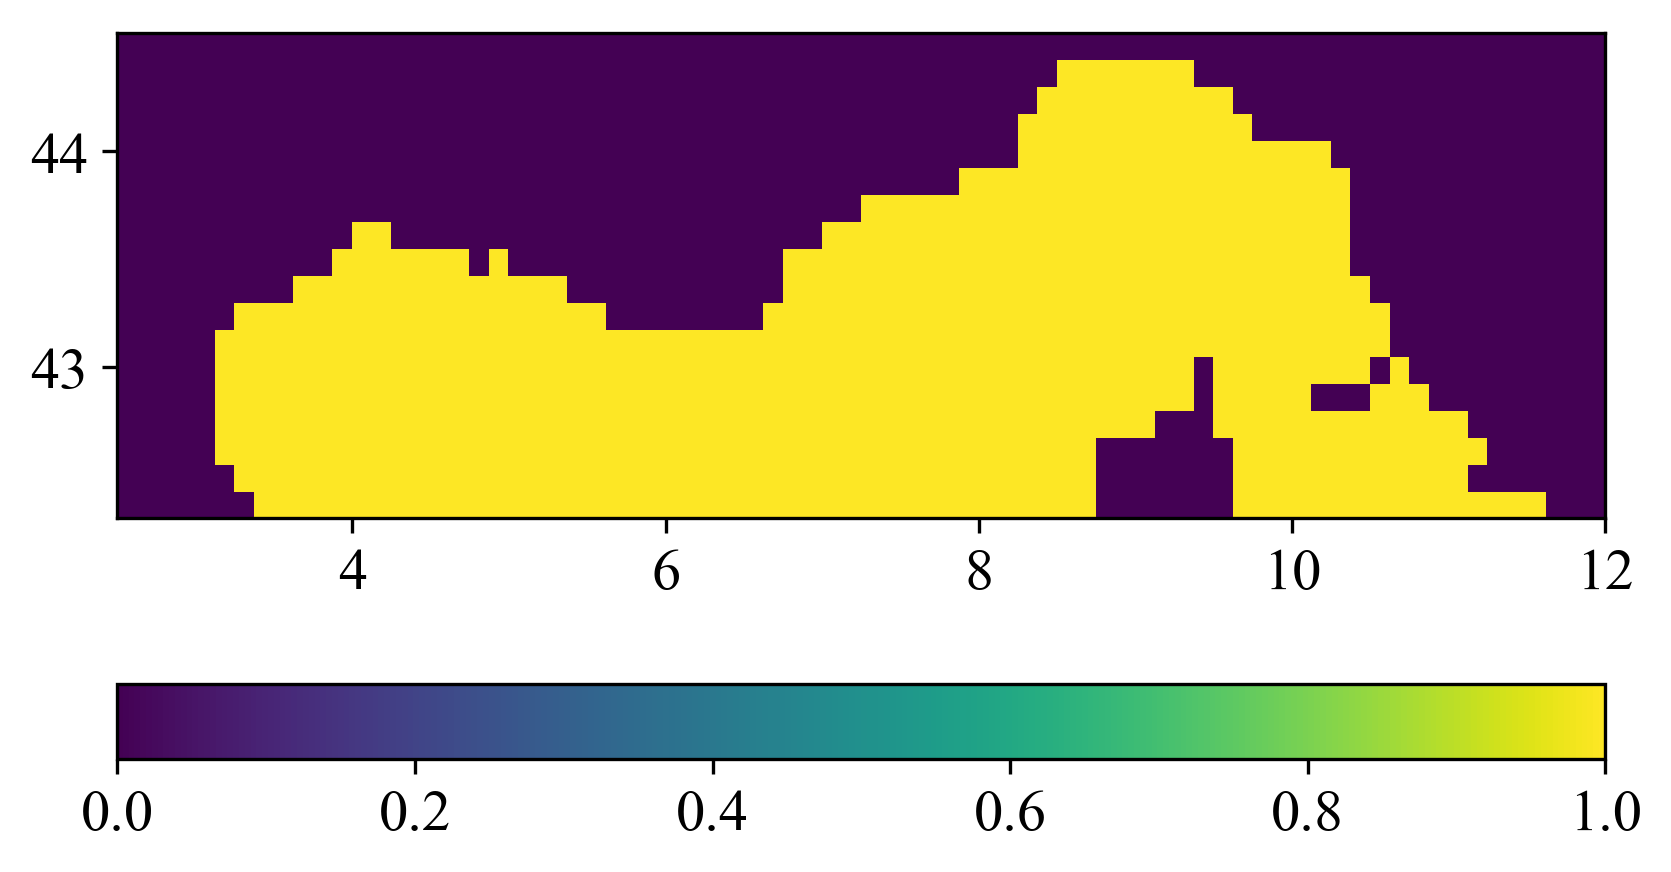

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[11]:3
└ @ Core In[11]:3


In [11]:
pcolor(xmask,ymask,Float64.(permutedims(mask[:,:,1], [2, 1]))); 
colorbar(orientation="horizontal")
gca().set_aspect(1/cos(mean([ylim()...]) * pi/180)) # fixes the aspect ratio

## Mask editing
To edit the mask, you can either modify directly its value if you know the indices, or you can use a selection based on the coordinates.
### Create an artificial island
We simply modify the mask at a given location.

In [12]:
# Create a copy of the mask for ediding
mask_copy = copy(mask);
mask_copy[63,8,:] .= false;

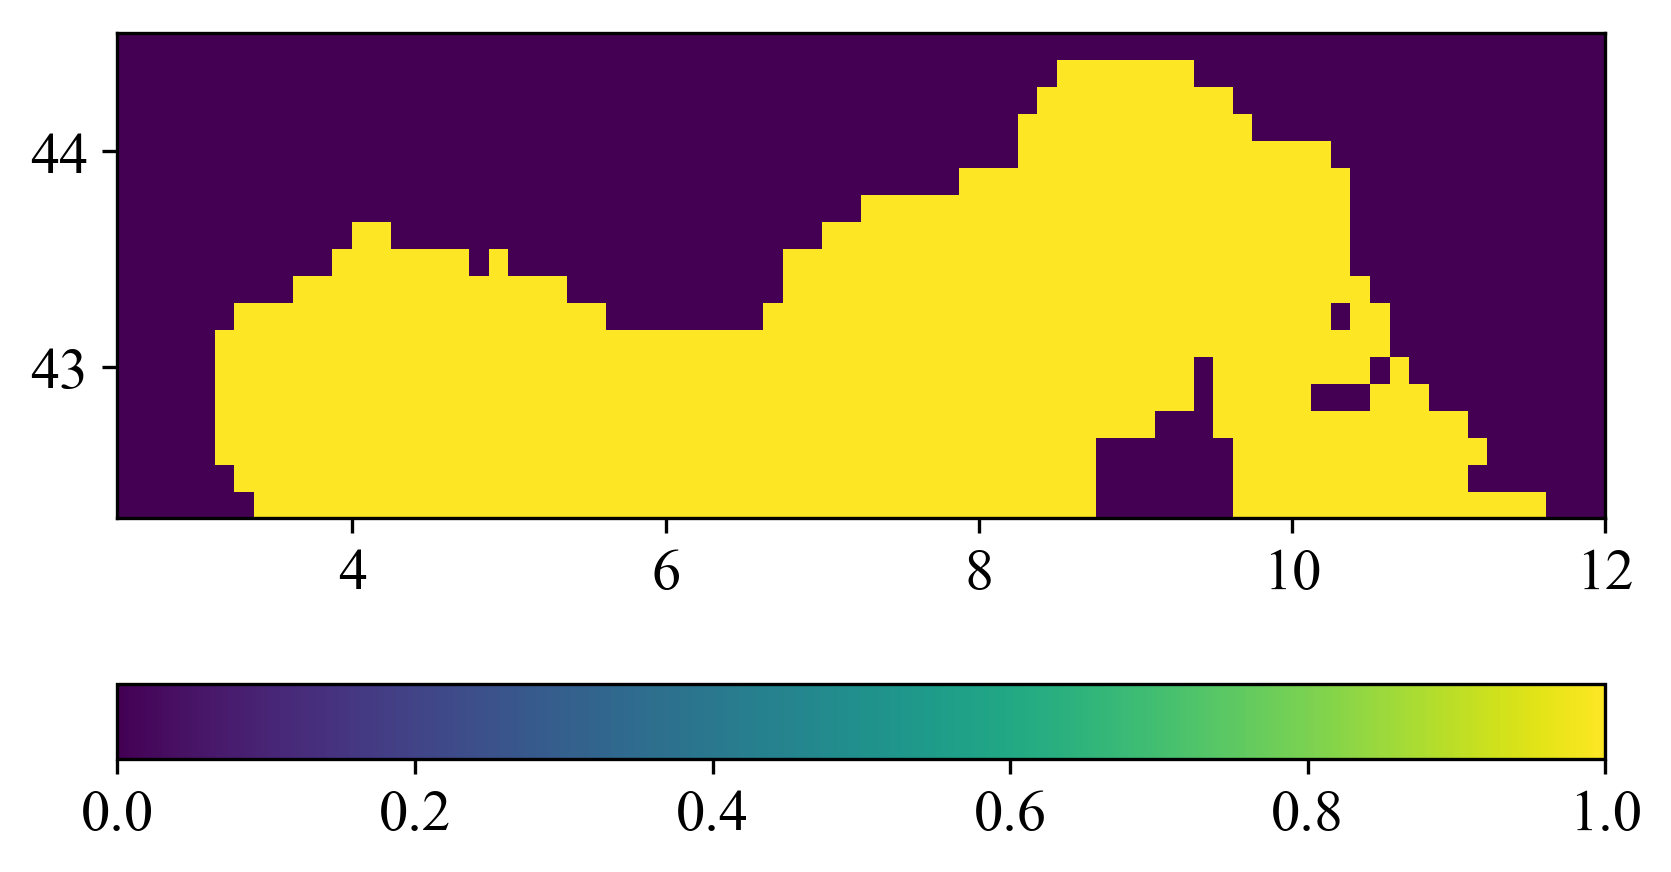

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[13]:3
└ @ Core In[13]:3


In [13]:
pcolor(bx, by, Float64.(permutedims(mask_copy[:,:,1], [2, 1]))); 
colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))

### Remove an island (based on indices)

In [14]:
mask_copy = copy(mask);
mask_copy[48:59,1:10,:] .= true;

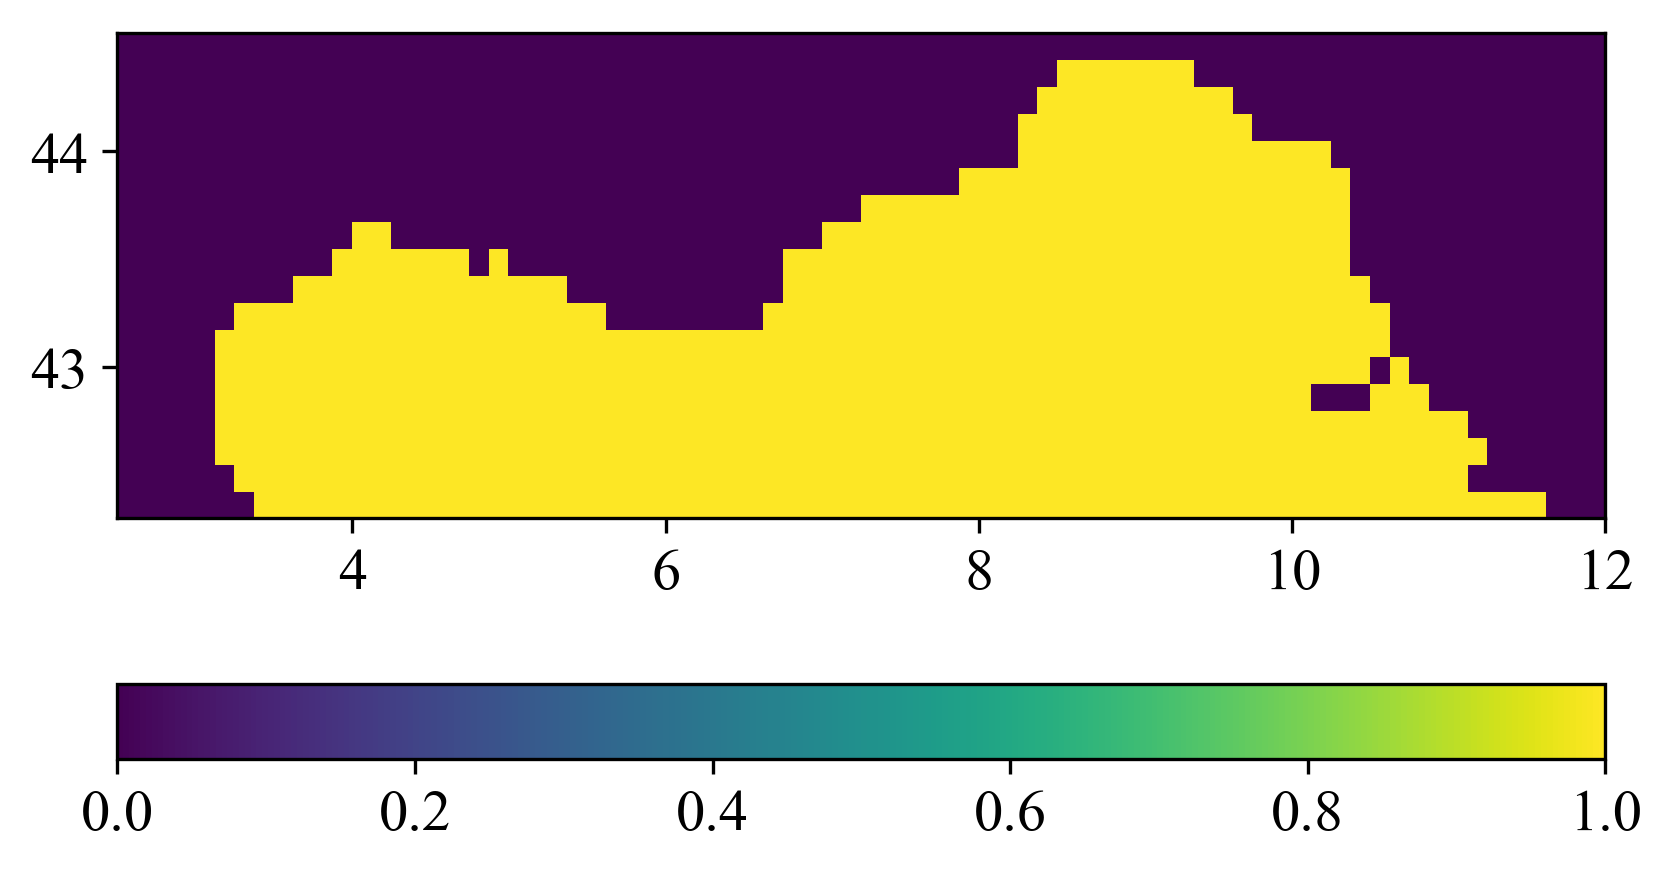

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[15]:3
└ @ Core In[15]:3


In [15]:
pcolor(bx, by, Float64.(permutedims(mask_copy[:,:,1], [2, 1]))); 
colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(Statistics.mean([ylim()...]) * pi/180))

### Remove an island (based on coordinates). 

This is the recommended approach as you can change resolution easily
`sel_lon` and `sel_lat` are obtained by checking the longitude and latitudes.

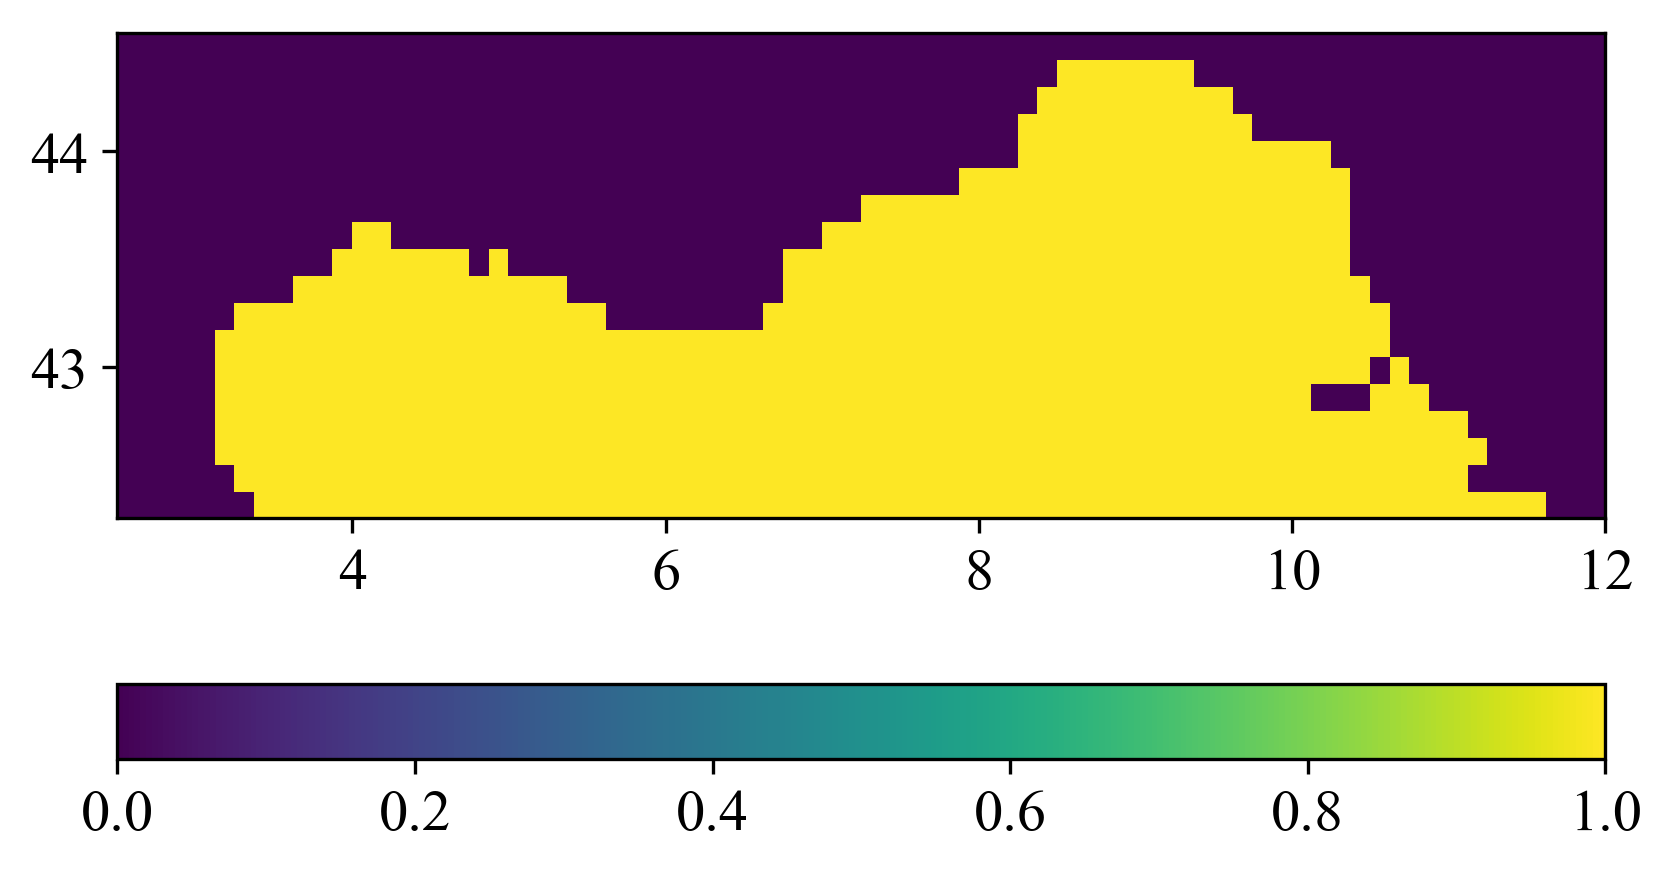

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[16]:7
└ @ Core In[16]:7


In [16]:
mask_copy = copy(mask);
sel_lon = (bx.>8) .& (bx.<10.);
sel_lat = (by.<43.25);
mask_copy[sel_lon, sel_lat, :] .= true;
pcolor(bx, by, Float64.(permutedims(mask_copy[:,:,1], [2, 1]))); 
colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(Statistics.mean([ylim()...]) * pi/180))

In [17]:
@show sel_lon;

sel_lon = Bool[false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, true, true, true, true, true, true, true, true, true, true, true, true, true, true, true, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false]


## Exercice
1. Load the bathymetry around the Black Sea.
2. Create a land sea mask for the following levels: 0, 150, 500 and 1000 meters.
3. Remove the Sea of Azov and the Sea of Marmara.
4. Plot the result.

The solution is available in [06-topography-BlackSea](./solutions/06-topography-BlackSea.ipynb) and should look like this:

<img src="./Images/BlackSea_mask.png" width="250px">